# 1D small world network

http://www.scholarpedia.org/article/Small-world_network <br>
https://en.wikipedia.org/wiki/Network_science

In [1]:
# run with spiNNaker

In [2]:
# fileName

fileName = 'eg_small-world_network'

In [3]:
try:
    import pyNN.spiNNaker as sim
except ModuleNotFoundError:
    import pyNN.brian2 as sim
    
from pyNN import space 
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pickle
import time
import datetime
import json
import warnings
warnings.filterwarnings('ignore')
import python_utils as pu
%matplotlib inline

savePath = f'../outputs/' # remember to create the folder if not already present (mkdir ./notebooks/outputs)
dt_string = datetime.datetime.today().isoformat() # ISO8601 ! :-)
tag = dt_string 
saveName = f'{savePath}{fileName}-{tag}'
print(saveName)
PARS={}


../outputs/eg_small-world_network-2025-06-04T20:04:30.968168


In [4]:
# simulation settings

sim.setup(
        timestep=1, # [ms]
        min_delay=1, # [ms]
        max_delay=100) # [ms]

simtime = 250 # [ms]


2025-06-04 20:04:30 INFO: Read cfg files: /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/interface/spinnaker.cfg, /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/spynnaker.cfg, /home/bbpnrsoa/.spynnaker.cfg
2025-06-04 20:04:30 INFO: Will search these locations for binaries: /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/common_model_binaries : /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/model_binaries
2025-06-04 20:04:30 WARNING: /home/bbpnrsoa/CNT-2025/notebooks/intro/reports has 12 old reports that have not been closed
2025-06-04 20:04:30 INFO: Setting time scale factor to 10.
2025-06-04 20:04:30 INFO: Setting machine time step to 1000 micro-seconds.


['/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/bbpnrsoa/.spynnaker.cfg']


In [5]:
# make the network

pops = {}
n_pops = {}
model_pops = {}

model_pops['cx'] = sim.IF_cond_exp
n_pops['cx'] = 100
v_init = sim.RandomDistribution('normal', (-65, 2))

pops['cx'] = sim.Population(
                            n_pops['cx'],
                            model_pops['cx'] ,
                            cellparams=sim.IF_cond_exp.default_parameters,
                            structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0),
                            initial_values = {'v' : v_init},
                            label=None,
                            constraints=None,
                            additional_parameters=None,
                            )


In [6]:
# make the connections 

# the region length where nodes will be connected locally.
degree = {'exc': 1.5,
          'inh': 1.5         
         }

# the probability of rewiring each edge.
rewiring = {'exc': 0.01,
            'inh': 0.01         
           }
 
# if specified, the number of efferent synaptic connections per neuron.
n_connections = {'exc': None,
                 'inh': None} 

conns = {}
for value in ['exc', 'inh']:
    conns['cx', 'cx', value] = sim.SmallWorldConnector(
                                                degree[value], 
                                                rewiring[value], 
                                                allow_self_connections=True,
                                                safe=True,
                                                verbose=True,
                                                n_connections = n_connections[value], 
                                                        )





In [7]:
# make the synapses

synapses = {}

delay = sim.RandomDistribution("normal_clipped", mu=1.5, sigma=1.75, low=0.1, high=100)

synapses['cx', 'cx', 'exc'] = sim.StaticSynapse(weight=0.1, delay=delay)
synapses['cx', 'cx', 'inh'] = sim.StaticSynapse(weight=0.5, delay=delay)
synapses['thal', 'cx'] = sim.StaticSynapse(weight=0.1, delay=1)


array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59])

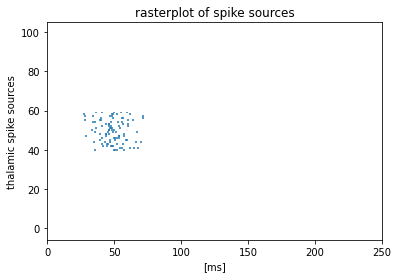

In [8]:
# make the thalamic input sources

n_pops['thal'] = n_pops['cx']

spike_times = [[]]*n_pops['thal'] #list of spike lists, where one spike list is related to one spike source

random_sources_idx = np.arange(int(n_pops['thal']*0.40), int(n_pops['thal']*0.60)) #[0,1,2]

for idx, sources in enumerate(random_sources_idx):
    spike_times[sources] = np.sort([abs(np.random.normal(loc=50, scale=10)) for n in range(5)])

model_pops['thal'] = sim.SpikeSourceArray(spike_times)

pops['thal'] = sim.Population(n_pops['thal'], 
                              model_pops['thal'])


fig, axes = plt.subplots(1,1)
axes_list = fig.axes
axes_list[0].eventplot(spike_times)
axes_list[0].set_xlabel('[ms]')
axes_list[0].set_ylabel('thalamic spike sources')
axes_list[0].set_title('rasterplot of spike sources')
axes_list[0].set_xlim(0, simtime)

random_sources_idx

In [9]:
# make the projections

projs = {}

projs['thal', 'cx'] = sim.Projection(pops['thal'], 
                                    pops['cx'],
                                    connector = sim.OneToOneConnector(),
                                    synapse_type = synapses['thal', 'cx'],
                                    space = sim.Space(axes='x', periodic_boundaries=((0,500), None, None)),
                                    receptor_type = 'excitatory')

projs['cx', 'cx', 'exc'] = sim.Projection(pops['cx'], 
                                         pops['cx'],
                                         connector = conns['cx', 'cx', 'exc'],
                                         synapse_type = synapses['cx', 'cx', 'exc'],
                                         space = sim.Space(axes='x', periodic_boundaries=((0,500), None, None)),
                                         receptor_type = 'excitatory')

projs['cx', 'cx', 'inh'] = sim.Projection(pops['cx'], 
                                         pops['cx'],
                                         connector = conns['cx', 'cx', 'inh'],
                                         synapse_type = synapses['cx', 'cx', 'inh'],
                                         space = sim.Space(axes='x', periodic_boundaries=((0,500), None, None)),
                                         receptor_type = 'inhibitory')

In [10]:
# record state variables

pops['cx'].record(['spikes','v','gsyn_exc','gsyn_inh'])   

pops['thal'].record(['spikes'])


In [11]:
# simulation run

tic = time.time()
sim.run(simtime)
toc = time.time() - tic

2025-06-04 20:04:31 INFO: Starting execution process
2025-06-04 20:04:31 INFO: Simulating for 250 1.0ms timesteps using a hardware timestep of 10000us
Adding Splitter selectors where appropriate
|0%                          50%                         100%|
2025-06-04 20:04:31 INFO: Time 0:00:00.012679 taken by SpynnakerSplitterSelector
Adding delay extensions as required
|0%                          50%                         100%|
2025-06-04 20:04:31 INFO: Time 0:00:00.013615 taken by DelaySupportAdder
2025-06-04 20:04:34 INFO: Time 0:00:03.384417 taken by SpallocMaxMachineGenerator
Preallocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2025-06-04 20:04:48 INFO: Time 0:00:13.134888 taken by PreAllocateResourcesForExtraMonitorSupport
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
2025-06-

In [12]:
# save results

stateVars = {}
for pop in pops.keys():
    for recording in ['v', 'gsyn_inh', 'gsyn_exc', 'spikes']:
        pops[pop].write_data(f'{saveName}-{recording}.pkl')
        stateVars[pop]=pops[pop].get_data()



Getting spikes for AbstractPopulationVertex_1
|0%                          50%                         100%|
Getting v for AbstractPopulationVertex_1
|0%                          50%                         100%|
Getting gsyn_exc for AbstractPopulationVertex_1
|0%                          50%                         100%|
Getting gsyn_inh for AbstractPopulationVertex_1
|0%                          50%                         100%|
Getting spikes for AbstractPopulationVertex_1
|0%                          50%                         100%|
Getting v for AbstractPopulationVertex_1
|0%                          50%                         100%|
Getting gsyn_exc for AbstractPopulationVertex_1
|0%                          50%                         100%|
Getting gsyn_inh for AbstractPopulationVertex_1
|0%                          50%                         100%|
Getting spikes for AbstractPopulationVertex_1
|0%                          50%                         100%|
Getting v for Abstrac

In [13]:
# recover results

stateVars.keys()
results = pu.recover_results(stateVars)
results.keys()


cx
v
gsyn_exc
gsyn_inh
thal


dict_keys([('cx', 'v'), ('cx', 'gsyn_exc'), ('cx', 'gsyn_inh'), ('cx', 'spikes'), ('thal', 'spikes')])

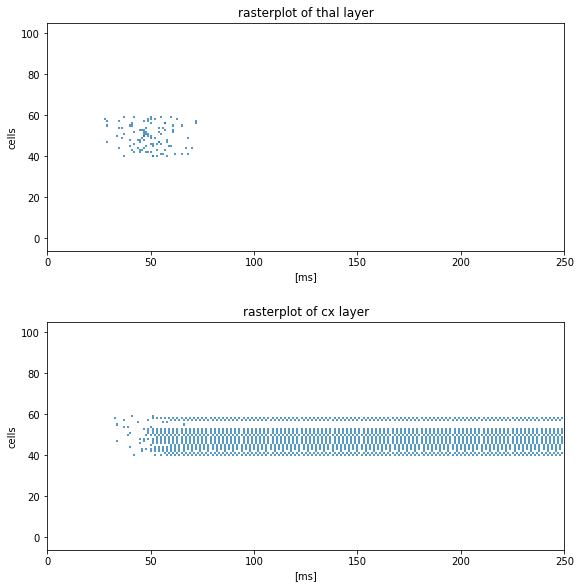

In [14]:
# check the spikes

fig, axes = plt.subplots(2,1, figsize=(9,9))
fig.tight_layout(pad=5)
axes_list = fig.axes

for idx, value in enumerate(['thal', 'cx']):
    axes_list[idx].eventplot(results[value, 'spikes'])
    axes_list[idx].set_title('rasterplot of ' + str(value) + ' layer')
    axes_list[idx].set_xlabel('[ms]')
    axes_list[idx].set_ylabel('cells')
    axes_list[idx].set_xlim(0, simtime)



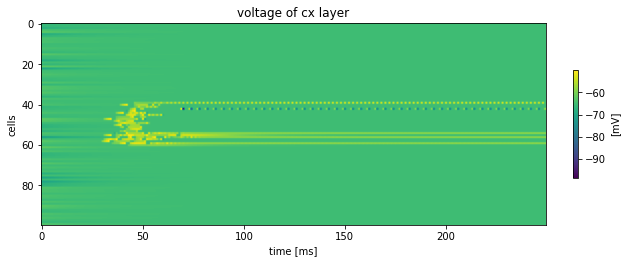

In [15]:
# check the voltage

fig, axes = plt.subplots(1, 1, figsize=(9,5))
fig.tight_layout(pad=4)

axes_list = fig.axes

for idx, value in enumerate(['cx']):
    im = axes_list[idx].imshow(results[value, 'v'].T)
    axes_list[idx].set_title('voltage of ' + str(value) + ' layer')
    axes_list[idx].set_xlabel('time [ms]')
    axes_list[idx].set_ylabel('cells')
    fig.colorbar(im, ax=axes_list[idx], fraction=0.010, label='[mV]')



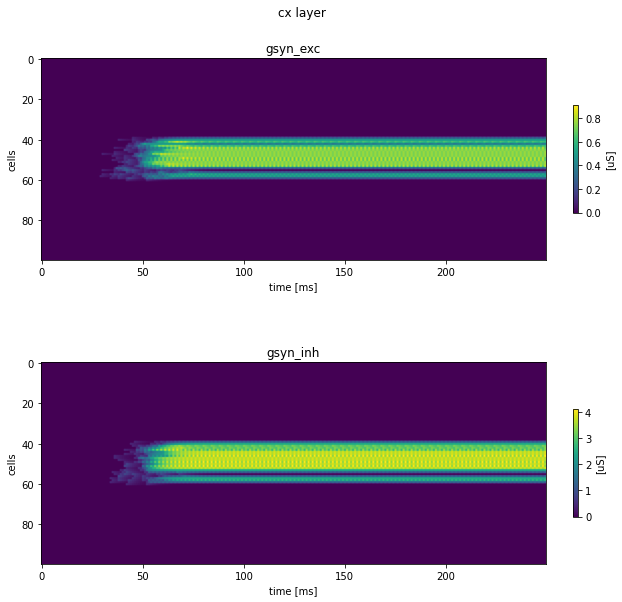

In [16]:
# check the conductances

for layer in ['cx']:
    fig, axes = plt.subplots(2, 1, figsize=(9,9))
    fig.tight_layout(pad=4)
    fig.suptitle(str(layer) + ' layer')
    axes_list = fig.axes
    
    for idx, gsyn in enumerate(['gsyn_exc', 'gsyn_inh']):
        im = axes_list[idx].imshow(results[layer, gsyn].T)
        axes_list[idx].set_title(str(gsyn))
        axes_list[idx].set_xlabel('time [ms]')
        axes_list[idx].set_ylabel('cells')
        fig.colorbar(im, ax=axes_list[idx], fraction=0.010, label='[uS]')


# check adjacent matrix

In [17]:
# check the small world projections

projs.keys()

dict_keys([('thal', 'cx'), ('cx', 'cx', 'exc'), ('cx', 'cx', 'inh')])

In [18]:
syn = {}

syn['exc'] = projs['cx', 'cx', 'exc'].get('source', 'target', 'list')
syn['inh'] = projs['cx', 'cx', 'inh'].get('source', 'target', 'list')



Getting synaptic data between AbstractPopulationVertex_1 and AbstractPopulationVertex_1
|0%                          50%                         100%|
Getting synaptic data between AbstractPopulationVertex_1 and AbstractPopulationVertex_1
|0%                          50%                         100%|


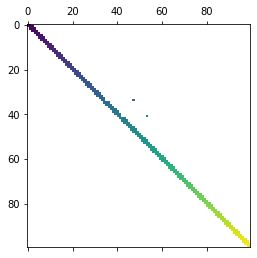

In [19]:
plt.matshow(syn['exc'])

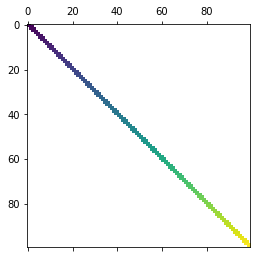

In [20]:
plt.matshow(syn['inh'])

In [21]:
# end simulation

sim.end()

2025-06-04 20:05:43 WARNING: The delays in the connector SmallWorldConnector from AbstractPopulationVertex_1 to AbstractPopulationVertex_1 was clipped to 1.0 a total of 62 times.  This can be avoided by reducing the timestep or increasing the minimum delay to one timestep
2025-06-04 20:05:43 WARNING: The delays in the connector SmallWorldConnector from AbstractPopulationVertex_1 to AbstractPopulationVertex_1 was clipped to 1.0 a total of 71 times.  This can be avoided by reducing the timestep or increasing the minimum delay to one timestep


# Task1: on the small-world network
- try to find in literature a 1D small-world network and use its parameter 
